In [180]:
import urllib.request
import gzip
import io
import json
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 0: Import data into useable type

# Labels make column-grabbing a lot easier
labels = ['id', 'gender', 'age', 'hypertension', 'heart_disease', 
          'ever_married', 'work_type', 'residence_type', 'avg_glucose_level', 
          'bmi', 'smoking_status', 'stroke']

dataset = pd.read_csv('healthcare-dataset-stroke-data.csv', names=labels)

# Clean null values from data, remove data we don't need
dataset = dataset.dropna()
dataset = dataset.iloc[1:]
dataset = dataset.drop(columns='id')
print(dataset.dtypes) # Column dtypes should be 'object' for cleaning to work

# Label Encoding allows us to assigns numbers to non-numerical columns 
# categorically.
dataset["gender"]           = dataset["gender"].astype('category')
dataset["bmi"]              = dataset["bmi"].astype('category')
dataset["ever_married"]     = dataset["ever_married"].astype('category')
dataset["work_type"]        = dataset["work_type"].astype('category')
dataset["residence_type"]   = dataset["residence_type"].astype('category')
dataset["smoking_status"]   = dataset["smoking_status"].astype("category")
dataset["stroke"]           = dataset["stroke"].astype("category")

dataset["gender"]           = dataset["gender"].cat.codes
dataset["bmi"]              = dataset["bmi"].cat.codes
dataset["ever_married"]     = dataset["ever_married"].cat.codes
dataset["work_type"]        = dataset["work_type"].cat.codes
dataset["residence_type"]   = dataset["residence_type"].cat.codes
dataset["smoking_status"]   = dataset["smoking_status"].cat.codes
dataset["stroke"]           = dataset["stroke"].cat.codes


dataset.head()
# Now data is clean and numerical, all that is left to do is select data
# to nomalize and use in training and testing.

gender               object
age                  object
hypertension         object
heart_disease        object
ever_married         object
work_type            object
residence_type       object
avg_glucose_level    object
bmi                  object
smoking_status       object
stroke               object
dtype: object


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,67,0,1,1,2,1,228.69,239,1,1
3,1,80,0,1,1,2,0,105.92,198,2,1
4,0,49,0,0,1,2,1,171.23,217,3,1
5,0,79,1,0,1,3,0,174.12,113,2,1
6,1,81,0,0,1,2,1,186.21,163,1,1


C:\Users\coxs4\AppData\Local\Programs\Python\Python37-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='stroke', ylabel='count'>

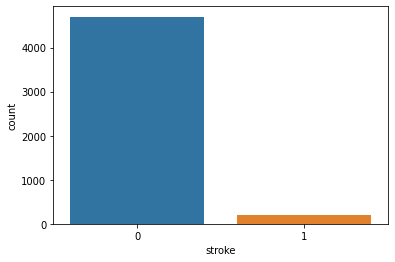

In [181]:
# Let's analyze data by looking at the classes and features
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(dataset['stroke'])

In [185]:
dataset['bmi'].fillna(dataset['bmi'].mean(), inplace = True)
dataset['smoking_status'].fillna(dataset['smoking_status'].mode()[0], inplace=True)
dataset.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [186]:
features = dataset.iloc[:, :-1].values
stroke = dataset.iloc[:, 10].values

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Split data
feature_train, feature_test, stroke_train, stroke_test = train_test_split(features, stroke, test_size=0.25)

# Normalize data
scaler = StandardScaler()
scaler.fit(feature_train)
feature_train = scaler.transform(feature_train)
feature_test = scaler.transform(feature_test)

# Classify with 3-nearest neighbors for KNN
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(feature_train, stroke_train)
# Predict
stroke_predictions = classifier.predict(feature_test)

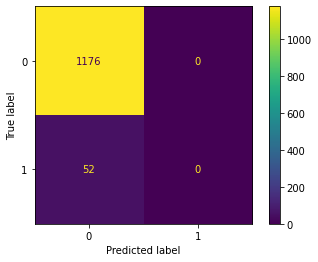

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1176
           1       0.12      0.02      0.03        52

    accuracy                           0.95      1228
   macro avg       0.54      0.51      0.50      1228
weighted avg       0.92      0.95      0.94      1228



In [203]:
# Analyze with confusion matrix & a report on the classification
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

clf = SVC(random_state=0)
clf.fit(feature_train, stroke_train)
SVC(random_state=0)
plot_confusion_matrix(clf, feature_test, stroke_test)

plt.show()
print(classification_report(stroke_test, stroke_predictions))

In [193]:
from sklearn.decomposition import PCA

# Compress from 10 components in the dataframe to 2
# We use 2 components so it can be easy to plot
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data = principal_components,
                     columns = ['pc1', 'pc2'])

class_df = pd.DataFrame(stroke, columns=['class'])
final_dataframe = pd.concat([pca_df, class_df[['class']]], axis = 1)
final_dataframe

,pc1,pc2,class
0,2.488343,3.766391,1
1,2.253259,2.464556,1
2,1.533631,-0.559837,1
3,1.925290,1.591865,1
4,1.422467,1.183818,1
...,...,...,...
4904,-2.946101,0.529339,0
4905,1.657340,-0.423320,0
4906,-0.052899,-0.773719,0
4907,0.468610,1.029739,0


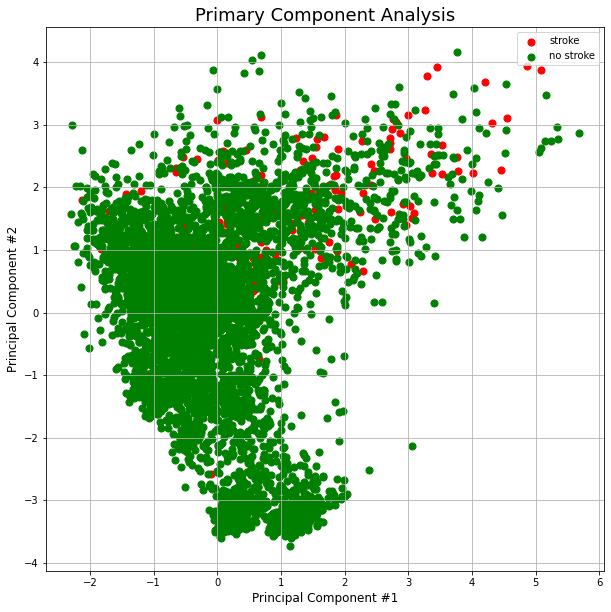

In [195]:
# Visualize PCA as it is the most interesting way to view results
pca_figure = plt.figure(figsize=(10, 10))
axis = pca_figure.add_subplot(1,1,1)
axis.set_title('Primary Component Analysis', fontsize=18)
axis.set_xlabel('Principal Component #1', fontsize=12)
axis.set_ylabel('Principal Component #2', fontsize=12)

legend1 = ['stroke', 'no stroke']
classes = [1, 0]
colors = ['red', 'green']

for x_match, color in zip(classes, colors):
    match = final_dataframe['class'] == x_match
    axis.scatter(final_dataframe.loc[match, 'pc2']
              , final_dataframe.loc[match, 'pc1']
              , c = color
              , s = 50)
axis.legend(legend1)
axis.grid()